In [24]:
'''A jupyter notebook detailing the use of the 
particle filter to fit a multi-strata model with a 
time dependent beta per age class. '''

'A jupyter notebook detailing the use of the \nparticle filter to fit a multi-strata model with a \ntime dependent beta per age class. '

In [25]:
# Construct a multistrata RUME

import matplotlib.pyplot as plt
import numpy as np
from sympy import Max

from epymorph.kit import *
from epymorph.adrio import acs5, us_tiger

from epymorph.forecasting.likelihood import Poisson,Gaussian,NegativeBinomial

from epymorph.forecasting.pipeline import (
    FromRUME,
    ParticleFilterSimulator,
    Observations,
    ModelLink,
)

In [26]:
my_rng = default_rng(1)

In [27]:


class MyRume(MultiStrataRUMEBuilder):
    strata = [
        GPM(
            name="age_00-19",
            ipm=ipm.SIRH(),
            mm=mm.No(),
            init=init.SingleLocation(location=0, seed_size=100),
        ),
        GPM(
            name="age_20-59",
            ipm=ipm.SIRH(),
            mm=mm.No(),
            init=init.NoInfection(),
        ),
        GPM(
            name="age_60-79",
            ipm=ipm.SIRH(),
            mm=mm.No(),
            init=init.NoInfection(),
        ),
    ]

    meta_requirements = [
        AttributeDef("beta_12", float, Shapes.TxN),
        AttributeDef("beta_13", float, Shapes.TxN),
        AttributeDef("beta_21", float, Shapes.TxN),
        AttributeDef("beta_23", float, Shapes.TxN),
        AttributeDef("beta_31", float, Shapes.TxN),
        AttributeDef("beta_32", float, Shapes.TxN),
    ]

    def meta_edges(self, symbols: MultiStrataModelSymbols) -> list[TransitionDef]:
        # extract compartment symbols by strata
        S_1, I_1, R_1,H_1 = symbols.strata_compartments("age_00-19")
        S_2, I_2, R_2,H_2 = symbols.strata_compartments("age_20-59")
        S_3, I_3, R_3,H_3 = symbols.strata_compartments("age_60-79")

        # extract compartment totals by strata
        N_1 = Max(1, S_1 + I_1 + R_1 + H_1)
        N_2 = Max(1, S_2 + I_2 + R_2 + H_2)
        N_3 = Max(1, S_3 + I_3 + R_3 + H_3)

        # extract meta attributes
        beta_12, beta_13, beta_21, beta_23, beta_31, beta_32 = (
            symbols.all_meta_requirements
        )

        return [
            edge(S_1, I_1, rate=S_1 * beta_12 * I_2 / N_2),  # 2 infects 1
            edge(S_1, I_1, rate=S_1 * beta_13 * I_3 / N_3),  # 3 infects 1
            edge(S_2, I_2, rate=S_2 * beta_21 * I_1 / N_1),  # 1 infects 2
            edge(S_2, I_2, rate=S_2 * beta_23 * I_3 / N_3),  # 3 infects 2
            edge(S_3, I_3, rate=S_3 * beta_31 * I_1 / N_1),  # 1 infects 3
            edge(S_3, I_3, rate=S_3 * beta_32 * I_2 / N_2),  # 2 infects 3
        ]

In [28]:
scope = CountyScope.in_counties(["King, WA"], year=2020)
time_frame = TimeFrame.of("2020-01-01", 180)

rume = MyRume().build(
    scope=scope,
    time_frame=time_frame,
    params={
        # IPM params
        "gpm:age_00-19::ipm::beta": 0.05,
        "gpm:age_20-59::ipm::beta": 0.20,
        "gpm:age_60-79::ipm::beta": 0.35,
        "*::ipm::gamma": 1 / 10,
        "gpm:age_00-19::ipm::hospitalization_prob": 0.001,
        "gpm:age_20-59::ipm::hospitalization_prob": 0.005,
        "gpm:age_60-79::ipm::hospitalization_prob":0.01,
        "*::ipm::hospitalization_duration":5,
        "*::ipm::xi": 1 / 90,
        "meta::ipm::beta_12": 0.05,
        "meta::ipm::beta_13": 0.05,
        "meta::ipm::beta_21": 0.20,
        "meta::ipm::beta_23": 0.20,
        "meta::ipm::beta_31": 0.35,
        "meta::ipm::beta_32": 0.35,

        # ADRIOs for population by age
        "*::*::population_by_age_table": acs5.PopulationByAgeTable(),
        "gpm:age_00-19::*::population": acs5.PopulationByAge(0, 19),
        "gpm:age_20-59::*::population": acs5.PopulationByAge(20, 59),
        "gpm:age_60-79::*::population": acs5.PopulationByAge(60, 79),
    },
)

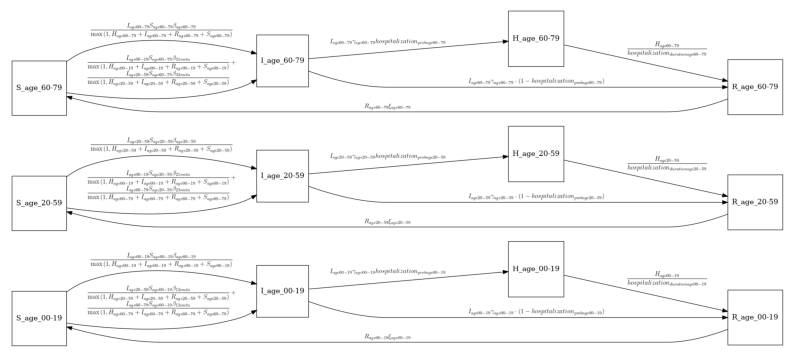

In [29]:
rume.ipm.diagram()

In [30]:
sim = BasicSimulator(rume)
with sim_messaging(live=False):
    out = sim.run(
        rng_factory=default_rng(1)
    )

Loading gpm:age_00-19::init::population_by_age_table (epymorph.adrio.acs5.PopulationByAgeTable):
  |####################| 100%  (0.615s)
Running simulation (BasicSimulator):
• 2020-01-01 to 2020-06-28 (180 days)
• 1 geo nodes
  |####################| 100% 
Runtime: 0.079s


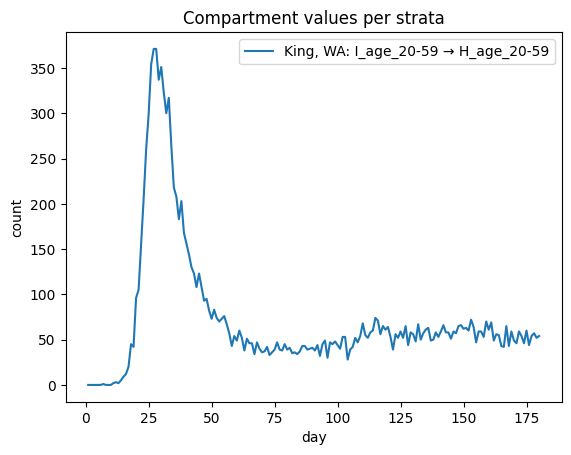

In [31]:
out.plot.line(
    geo=out.rume.scope.select.all(),
    time=out.rume.time_frame.select.all(),
    quantity=out.rume.ipm.select.events("I*->H_age_20-59"),
    title="Compartment values per strata",
)

In [32]:
# Plot the compartment values in States throughout the simulation.
from epymorph.adrio import csv
from epymorph.tools.data import munge

cases_df = munge(
    out,
    quantity=rume.ipm.select.events("I*->H_age_20-59"),
    time=rume.time_frame.select.all().group("day").agg(),
    geo=rume.scope.select.all(),
)

cases_df.columns = ['date','geoid','value']

cases_df.to_csv('pf_vignettes/synthetic_data.csv',index=False)

csvadrio = csv.CSVFileAxN(
    file_path='pf_vignettes/synthetic_data.csv',
    dtype=np.int64,
    key_col=1,
    key_type="geoid",
    time_col=0,
    data_col=2,
    skiprows=1
)

In [33]:
class PfRume(MultiStrataRUMEBuilder):
    strata = [
        GPM(
            name="age_00-19",
            ipm=ipm.SIRH(),
            mm=mm.No(),
            init=init.RandomLocationsAndRandomSeed(num_locations=1, seed_max=1000),
        ),
        GPM(
            name="age_20-59",
            ipm=ipm.SIRH(),
            mm=mm.No(),
            init=init.RandomLocationsAndRandomSeed(num_locations=1, seed_max=1000),
        ),
        GPM(
            name="age_60-79",
            ipm=ipm.SIRH(),
            mm=mm.No(),
            init=init.RandomLocationsAndRandomSeed(num_locations=1, seed_max=1000),
        ),
    ]

    meta_requirements = [
        AttributeDef("beta_12", float, Shapes.TxN),
        AttributeDef("beta_13", float, Shapes.TxN),
        AttributeDef("beta_21", float, Shapes.TxN),
        AttributeDef("beta_23", float, Shapes.TxN),
        AttributeDef("beta_31", float, Shapes.TxN),
        AttributeDef("beta_32", float, Shapes.TxN),
    ]

    def meta_edges(self, symbols: MultiStrataModelSymbols) -> list[TransitionDef]:
        # extract compartment symbols by strata
        S_1, I_1, R_1,H_1 = symbols.strata_compartments("age_00-19")
        S_2, I_2, R_2,H_2 = symbols.strata_compartments("age_20-59")
        S_3, I_3, R_3,H_3 = symbols.strata_compartments("age_60-79")

        # extract compartment totals by strata
        N_1 = Max(1, S_1 + I_1 + R_1 + H_1)
        N_2 = Max(1, S_2 + I_2 + R_2 + H_2)
        N_3 = Max(1, S_3 + I_3 + R_3 + H_3)

        # extract meta attributes
        beta_12, beta_13, beta_21, beta_23, beta_31, beta_32 = (
            symbols.all_meta_requirements
        )

        return [
            edge(S_1, I_1, rate=S_1 * beta_12 * I_2 / N_2),  # 2 infects 1
            edge(S_1, I_1, rate=S_1 * beta_13 * I_3 / N_3),  # 3 infects 1
            edge(S_2, I_2, rate=S_2 * beta_21 * I_1 / N_1),  # 1 infects 2
            edge(S_2, I_2, rate=S_2 * beta_23 * I_3 / N_3),  # 3 infects 2
            edge(S_3, I_3, rate=S_3 * beta_31 * I_1 / N_1),  # 1 infects 3
            edge(S_3, I_3, rate=S_3 * beta_32 * I_2 / N_2),  # 2 infects 3
        ]

In [34]:
num_realizations = 100

pf_rume = PfRume().build(
    scope=scope,
    time_frame=time_frame,
    params={
        # IPM params
        "gpm:age_00-19::ipm::beta": 0.05,
        "gpm:age_20-59::ipm::beta": 0.20,
        "gpm:age_60-79::ipm::beta": 0.35,
        "*::ipm::gamma": 1 / 10,
        "gpm:age_00-19::ipm::hospitalization_prob": 0.001,
        "gpm:age_20-59::ipm::hospitalization_prob": 0.005,
        "gpm:age_60-79::ipm::hospitalization_prob":0.01,
        "*::ipm::hospitalization_duration":5,
        "*::ipm::xi": 1 / 90,
        "meta::ipm::beta_12": 0.05,
        "meta::ipm::beta_13": 0.05,
        "meta::ipm::beta_21": 0.20,
        "meta::ipm::beta_23": 0.20,
        "meta::ipm::beta_31": 0.35,
        "meta::ipm::beta_32": 0.35,

        # ADRIOs for population by age
        "*::*::population_by_age_table": acs5.PopulationByAgeTable(),
        "gpm:age_00-19::*::population": acs5.PopulationByAge(0, 19),
        "gpm:age_20-59::*::population": acs5.PopulationByAge(20, 59),
        "gpm:age_60-79::*::population": acs5.PopulationByAge(60, 79),
    },
)

my_observations = Observations(
    source=csvadrio,
    model_link=ModelLink(
        geo=rume.scope.select.all(),
        time=rume.time_frame.select.all().group("day").agg(),
        quantity=rume.ipm.select.events("I*->H_age_20-59"),
    ),
    likelihood=Poisson(),
)

particle_filter_simulator = ParticleFilterSimulator(
        config=FromRUME(rume,num_realizations),
        observations=my_observations,
        save_trajectories=True,
    )


In [35]:
particle_filter_output = particle_filter_simulator.run(rng=my_rng)

MissingContextError: Missing function context 'data' during evaluation.
The simulation function tried to access 'data' but this has not been provided. Call `with_context()` first, providing all context that is required by this function. Then call `evaluate()` on the returned object to compute the value.